In [1]:
from tensorflow import keras
import tensorflow as tf
from enum import Enum


import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import zipfile
import os



## 데이터 로드

In [2]:
setattr(tfds.image_classification.cats_vs_dogs,
'_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

dataset = tfds.load('cats_vs_dogs', as_supervised=False)

In [3]:
# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # Split dataset into 80% train and 20% test
    shuffle_files=True,
    as_supervised=True,  # Use True to get (image, label) pairs
    with_info=True,  # To retrieve dataset information
)

In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32` and resizes to (244, 244)."""
    try:
        # 이미지 크기 조정
        image = tf.image.resize(image, [244, 244])
        # 이미지 정규화
        return tf.cast(image, tf.float32) / 255., label
    except tf.errors.InvalidArgumentError:
        # 손상된 이미지는 None을 반환하여 건너뜀
        return None, None


In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    """데이터셋에 정규화 및 리사이즈 적용합니다."""
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE  # 성능 최적화를 위해 AUTOTUNE 사용
    )

    # None을 필터링하여 손상된 이미지 및 레이블 제거
  #  ds = ds.filter(lambda img, lbl: tf.logical_and(tf.reduce_all(img is not None), lbl is not None))

    # 데이터셋 카디널리티 확인
    cardinality = tf.data.experimental.cardinality(ds).numpy()
    print(f'필터링 후 데이터셋 크기: {cardinality}')

    ds = ds.batch(batch_size)  # 배치 처리
    if not is_test:
        ds = ds.shuffle(200)  # 데이터셋 섞기
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 성능 최적화를 위한 사전 로드
    return ds


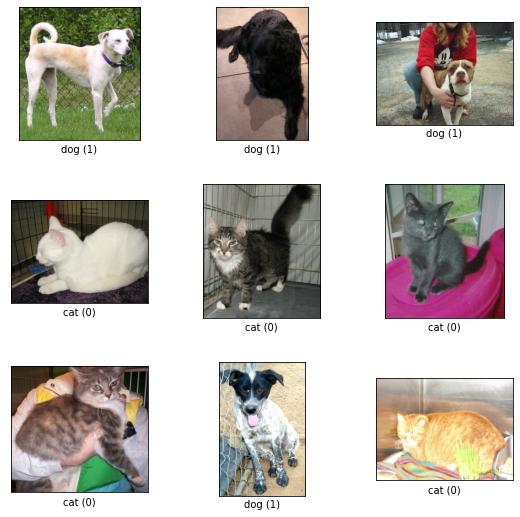

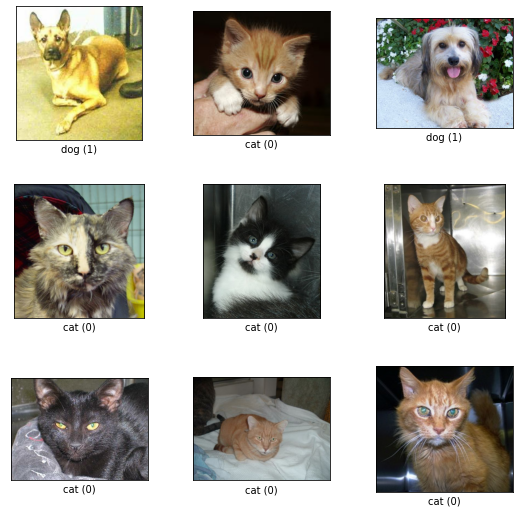

In [7]:
ds_info.features["label"].num_classes
ds_info.features["label"].names
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [8]:
# 데이터셋에 정규화 및 리사이즈 적용
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=16)

필터링 후 데이터셋 크기: 18610
필터링 후 데이터셋 크기: 4652


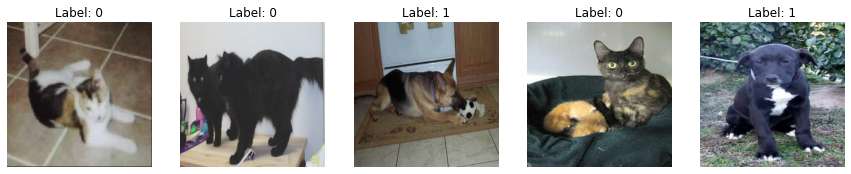

In [9]:
def visualize_samples(ds, num_samples=5):
    """주어진 데이터셋에서 샘플을 시각화합니다."""
    plt.figure(figsize=(15, 6))
    for i, (image_batch, label_batch) in enumerate(ds.take(1)):  # 1배치만 가져오기
        for j in range(num_samples):
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(image_batch[j].numpy())  # 각 이미지에 대해 시각화
            plt.title("Label: {}".format(label_batch[j].numpy()))
            plt.axis('off')
    plt.show()

# 시각화 샘플
visualize_samples(ds_train)


## ResNet model 모듈화

In [10]:
class ResNetModels(Enum):
    RESNET_34 = 1
    RESNET_34_PLAIN = 2
    RESNET_50 = 3
    RESNET_50_PLAIN = 4

In [20]:
class ResNet:
    def __init__(self, model_type: ResNetModels, input_shape=(244, 244, 3), num_cnn_list=[3, 4, 6, 3], channel_list=[64, 128, 256, 512]):
        self.input_shape = input_shape
        self.num_cnn_list = num_cnn_list
        self.channel_list = channel_list
        self.model_type = model_type
        self.model = self.build_resnet()

    def conv_block(self, input_layer, channel, kernel_size, strides=1, activation='relu'):
        """Convolutional block with Batch Normalization and Activation."""
        x = keras.layers.Conv2D(filters=channel,
                                 kernel_size=kernel_size,
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=keras.regularizers.l2(1e-4),
                                 padding='same',
                                 strides=strides)(input_layer)
        x = keras.layers.BatchNormalization()(x)
        if activation:
            x = keras.layers.Activation(activation)(x)
        return x

    def add_shortcut(self, x, num_cnn=3, channel=64, block_num=0):
        """Add shortcut connections and build blocks."""
        if self.model_type  == ResNetModels.RESNET_34:
            for i in range(num_cnn):
                if block_num > 0 and i == 0:
                    shortcut = self.conv_block(x, channel, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (3, 3), strides=2)
                    x = self.conv_block(x, channel, (3, 3), activation=None)
                else:
                    shortcut = x
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel, (3, 3), activation=None)

                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        
        elif self.model_type == ResNetModels.RESNET_34_PLAIN:
            for i in range(num_cnn):
                if block_num > 0 and i == 0:
                    #shortcut = self.conv_block(x, channel, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (3, 3), strides=2)
                    x = self.conv_block(x, channel, (3, 3), activation=None)
                else:
                    shortcut = x
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel, (3, 3), activation=None)

                    #x = keras.layers.Add()([x, shortcut])
                    x = keras.layers.Activation('relu')(x)
        
        
        elif self.model_type == ResNetModels.RESNET_50:
            for i in range(num_cnn):
                if i == 0:
                    shortcut = self.conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (1, 1), strides=2)
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)
                else:
                    shortcut = x
                    x = self.conv_block(x, channel, (1, 1))
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)

                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        
        elif self.model_type ==  ResNetModels.RESNET_50_PLAIN:
            for i in range(num_cnn):
                if i == 0:
                  #  shortcut = self.conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (1, 1), strides=2)
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)
                else:
                  #  shortcut = x
                    x = self.conv_block(x, channel, (1, 1))
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)

                #x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
            
        return x

    def build_resnet(self):
        """Build the ResNet model."""
        assert len(self.num_cnn_list) == len(self.channel_list), "num_cnn_list와 channel_list의 길이가 같아야 합니다."

        input_layer = keras.layers.Input(shape=self.input_shape)
        x = self.conv_block(input_layer, 64, (7, 7), strides=2)
        x = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)  

        for block_num, (num_cnn, channel) in enumerate(zip(self.num_cnn_list, self.channel_list)):
            x = self.add_shortcut(x, num_cnn=num_cnn, channel=channel, block_num=block_num)

        x = keras.layers.AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units=1000, activation='softmax')(x)

        return keras.models.Model(inputs=input_layer, outputs=x)
    
    def compile(self, optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        """Compile the model."""
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    def fit(self, ds_train, epochs=10, validation_data=None, batch_size=16):
        """모델을 학습하고 히스토리를 반환합니다."""
        # Calculate total number of samples in ds_train and ds_validation
        total_samples_train = tf.data.experimental.cardinality(ds_train).numpy() * batch_size
        steps_per_epoch = total_samples_train // batch_size  # Calculate steps per epoch

        if validation_data is not None:
            total_samples_validation = tf.data.experimental.cardinality(validation_data).numpy() * batch_size
            validation_steps = total_samples_validation // batch_size  # Calculate validation steps
        else:
            validation_steps = None

        history = self.model.fit(
            ds_train,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=validation_steps,
            verbose=1
        )
        return history



In [21]:
resnet_34 = ResNet(model_type=ResNetModels.RESNET_34)

In [22]:
resnet_34_plain = ResNet(model_type=ResNetModels.RESNET_34_PLAIN)

In [23]:
resnet_50 = ResNet(model_type=ResNetModels.RESNET_50)

In [24]:
resnet_50_plain = ResNet(model_type = ResNetModels.RESNET_50_PLAIN)

## resnet model 그래프

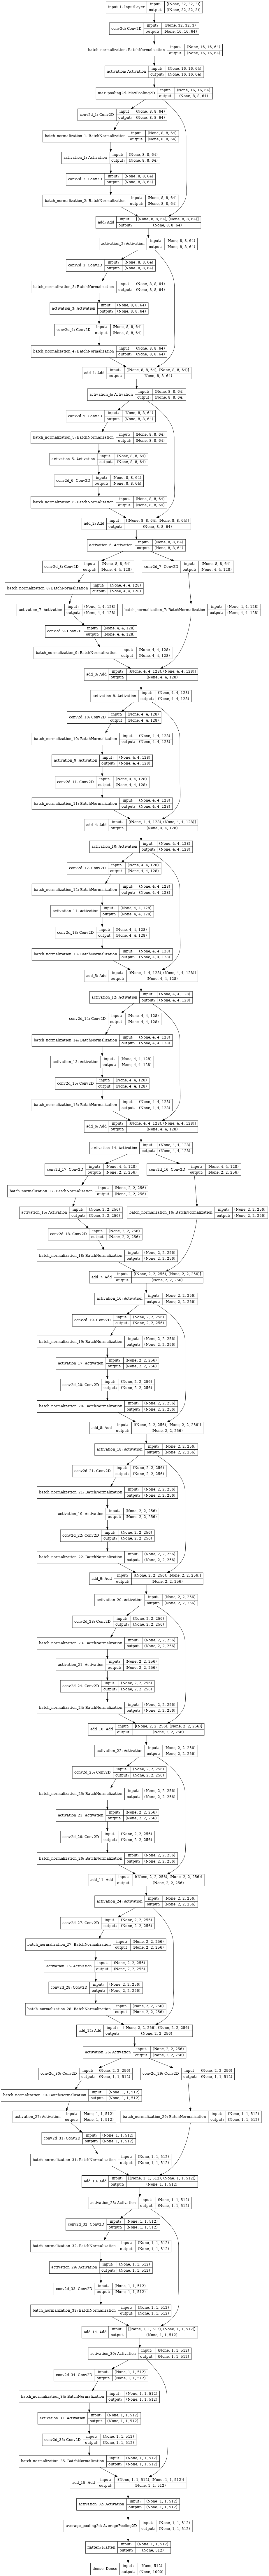

In [7]:
tf.keras.utils.plot_model(resnet_34.model, show_shapes=True, dpi=64)

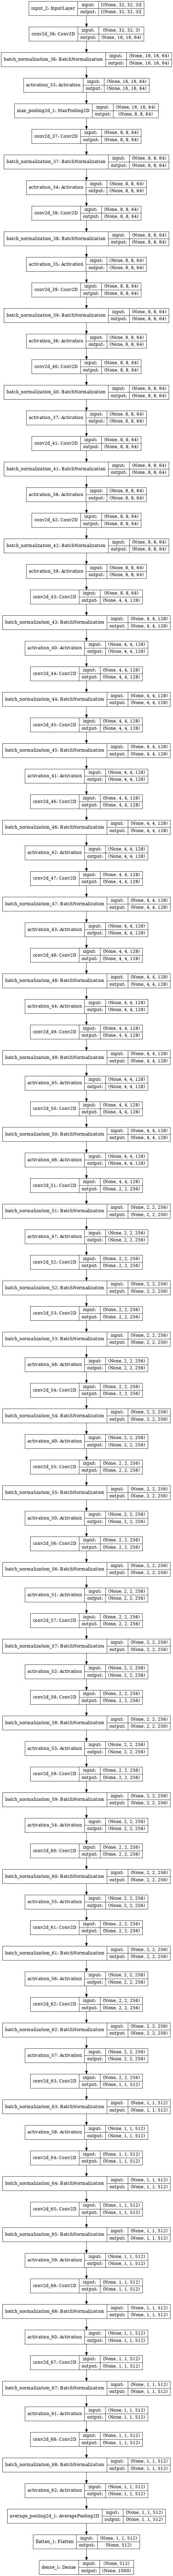

In [11]:
tf.keras.utils.plot_model(resnet_34_plain.model, show_shapes=True, dpi=64)

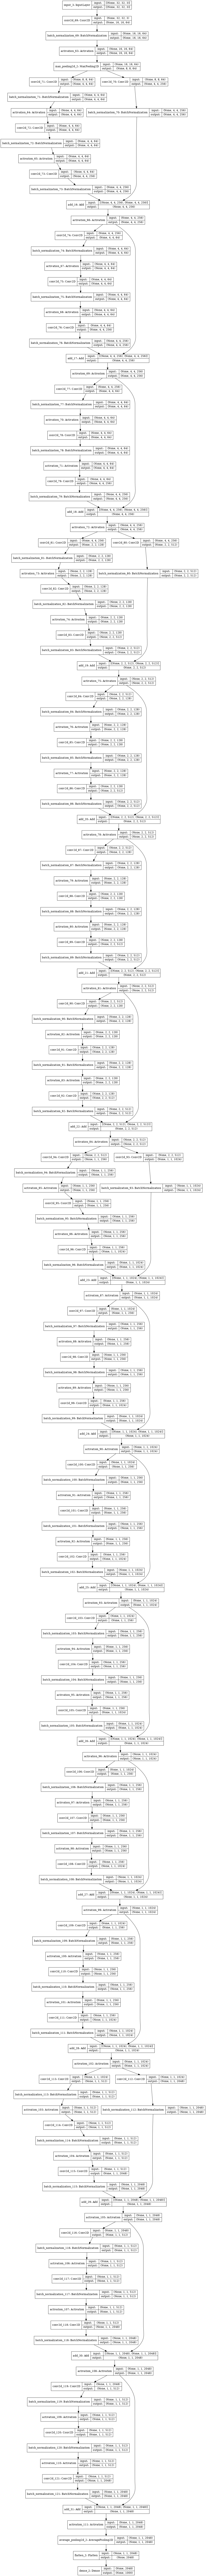

In [14]:
tf.keras.utils.plot_model(resnet_50.model,show_shapes=True, dpi = 64)

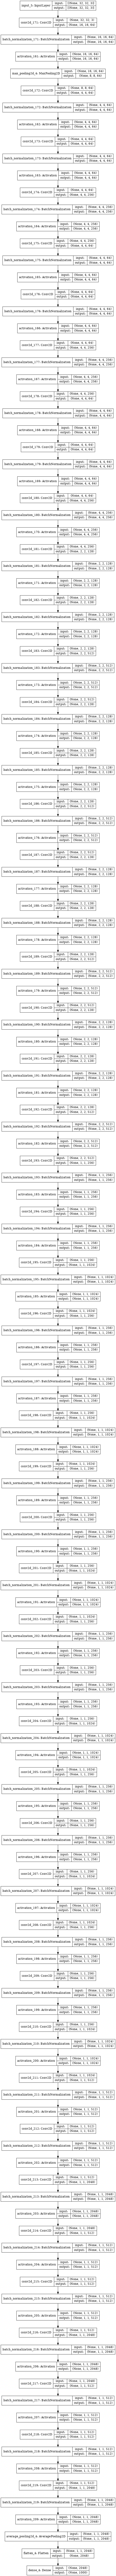

In [17]:
tf.keras.utils.plot_model(resnet_50_plain.model, show_shapes= True, dpi = 64)

## 시각화 함수

In [31]:
def compare_history_error(history1, history2, label1, label2):
    # 손실(loss) 값을 error로 간주하여 플로팅
    train_error1 = history1.history['loss']
    val_error1 = history1.history['val_loss']
    train_error2 = history2.history['loss']
    val_error2 = history2.history['val_loss']
    
    epochs = range(1, len(train_error1) + 1)

    plt.figure(figsize=(10, 6))
    
    # 첫 번째 모델 (얇은 곡선은 훈련 오류, 굵은 곡선은 검증 오류) - 빨간색 계열
    plt.plot(epochs, train_error1, 'r-', label=f'{label1} train error', linewidth=1)  # 얇은 훈련 곡선 (빨강)
    plt.plot(epochs, val_error1, 'r-', label=f'{label1} val error', linewidth=3, alpha=0.7)  # 굵은 검증 곡선 (빨강)
    
    # 두 번째 모델 (얇은 곡선은 훈련 오류, 굵은 곡선은 검증 오류) - 파란색 계열
    plt.plot(epochs, train_error2, 'b-', label=f'{label2} train error', linewidth=1)  # 얇은 훈련 곡선 (파랑)
    plt.plot(epochs, val_error2, 'b-', label=f'{label2} val error', linewidth=3, alpha=0.7)  # 굵은 검증 곡선 (파랑)
    
    # 그래프의 제목과 축 라벨 설정
    plt.title('Training and Validation Error Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Error (Loss)')
    
    # 범례 추가
    plt.legend()
    
    # 그래프 출력
    plt.show()


## resnet 34  모델 학습

In [53]:
for images, labels in ds_train.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (16, 244, 244, 3)
Labels shape: (16,)


In [16]:
resnet_34.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# ds_train과 ds_test를 사용하여 학습 수행
resnet_34_history = resnet_34.fit(ds_train, epochs= 10, validation_data=ds_test)

Epoch 1/10
 195/1164 [====>.........................] - ETA: 1:49 - loss: 3.0197 - accuracy: 0.5609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:42 - loss: 2.8589 - accuracy: 0.5876

 281/1164 [======>.......................] - ETA: 1:39 - loss: 2.8108 - accuracy: 0.5910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:23 - loss: 2.6536 - accuracy: 0.6069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 832/1164 [====================>.........] - ETA: 37s - loss: 2.4987 - accuracy: 0.6192

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1164 [=====================>........] - ETA: 34s - loss: 2.4916 - accuracy: 0.6208

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 32s - loss: 2.4876 - accuracy: 0.6222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 26s - loss: 2.4777 - accuracy: 0.6250

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 24s - loss: 2.4752 - accuracy: 0.6257

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.4429 - accuracy: 0.6341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 189s 125ms/step - loss: 2.4429 - accuracy: 0.6341 - val_loss: 2.5347 - val_accuracy: 0.5692
Epoch 2/10
 189/1164 [===>..........................] - ETA: 1:53 - loss: 2.3042 - accuracy: 0.6716

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:46 - loss: 2.3017 - accuracy: 0.6702

 277/1164 [======>.......................] - ETA: 1:43 - loss: 2.2991 - accuracy: 0.6724

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:25 - loss: 2.2962 - accuracy: 0.6784

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 38s - loss: 2.2835 - accuracy: 0.6852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 35s - loss: 2.2839 - accuracy: 0.6853

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 32s - loss: 2.2830 - accuracy: 0.6862

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 2.2804 - accuracy: 0.6882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 24s - loss: 2.2805 - accuracy: 0.6885

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2709 - accuracy: 0.6970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 2.2709 - accuracy: 0.6970 - val_loss: 2.2606 - val_accuracy: 0.7070
Epoch 3/10
 191/1164 [===>..........................] - ETA: 1:53 - loss: 2.2410 - accuracy: 0.7287

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:45 - loss: 2.2336 - accuracy: 0.7303

 274/1164 [======>.......................] - ETA: 1:43 - loss: 2.2334 - accuracy: 0.7318

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:26 - loss: 2.2277 - accuracy: 0.7290

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 38s - loss: 2.2167 - accuracy: 0.7359

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 35s - loss: 2.2146 - accuracy: 0.7369

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 32s - loss: 2.2128 - accuracy: 0.7381

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.2118 - accuracy: 0.7389

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 24s - loss: 2.2114 - accuracy: 0.7391

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2038 - accuracy: 0.7438

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 2.2038 - accuracy: 0.7438 - val_loss: 2.2472 - val_accuracy: 0.7214
Epoch 4/10
 190/1164 [===>..........................] - ETA: 1:53 - loss: 2.1674 - accuracy: 0.7628

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:46 - loss: 2.1652 - accuracy: 0.7662

 276/1164 [======>.......................] - ETA: 1:43 - loss: 2.1620 - accuracy: 0.7704

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:26 - loss: 2.1646 - accuracy: 0.7688

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 37s - loss: 2.1441 - accuracy: 0.7811

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 35s - loss: 2.1453 - accuracy: 0.7805

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 32s - loss: 2.1448 - accuracy: 0.7804

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 26s - loss: 2.1429 - accuracy: 0.7823

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 24s - loss: 2.1429 - accuracy: 0.7821

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1358 - accuracy: 0.7856

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 2.1358 - accuracy: 0.7856 - val_loss: 2.1154 - val_accuracy: 0.8046
Epoch 5/10
 194/1164 [====>.........................] - ETA: 1:53 - loss: 2.0771 - accuracy: 0.8196

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:46 - loss: 2.0787 - accuracy: 0.8147

 273/1164 [======>.......................] - ETA: 1:43 - loss: 2.0804 - accuracy: 0.8136

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:26 - loss: 2.0899 - accuracy: 0.8116

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 2.0823 - accuracy: 0.8150

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 35s - loss: 2.0821 - accuracy: 0.8154

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 32s - loss: 2.0834 - accuracy: 0.8152

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 26s - loss: 2.0817 - accuracy: 0.8156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 24s - loss: 2.0799 - accuracy: 0.8164

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0738 - accuracy: 0.8196

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 2.0738 - accuracy: 0.8196 - val_loss: 2.1401 - val_accuracy: 0.7805
Epoch 6/10
 193/1164 [===>..........................] - ETA: 1:53 - loss: 2.0205 - accuracy: 0.8436

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:45 - loss: 2.0243 - accuracy: 0.8428

 276/1164 [======>.......................] - ETA: 1:43 - loss: 2.0247 - accuracy: 0.8422

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 422/1164 [=========>....................] - ETA: 1:26 - loss: 2.0262 - accuracy: 0.8442

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 38s - loss: 2.0223 - accuracy: 0.8456

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 35s - loss: 2.0217 - accuracy: 0.8463

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 32s - loss: 2.0207 - accuracy: 0.8464

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.0187 - accuracy: 0.8470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 24s - loss: 2.0175 - accuracy: 0.8474

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0098 - accuracy: 0.8516

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 2.0098 - accuracy: 0.8516 - val_loss: 2.1500 - val_accuracy: 0.8046
Epoch 7/10
 191/1164 [===>..........................] - ETA: 1:53 - loss: 1.9372 - accuracy: 0.8874

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:46 - loss: 1.9368 - accuracy: 0.8877

 277/1164 [======>.......................] - ETA: 1:43 - loss: 1.9378 - accuracy: 0.8872

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:26 - loss: 1.9388 - accuracy: 0.8878

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 37s - loss: 1.9297 - accuracy: 0.8911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 35s - loss: 1.9303 - accuracy: 0.8910

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 32s - loss: 1.9286 - accuracy: 0.8918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 26s - loss: 1.9271 - accuracy: 0.8924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 24s - loss: 1.9270 - accuracy: 0.8924

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9254 - accuracy: 0.8929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 1.9254 - accuracy: 0.8929 - val_loss: 2.1936 - val_accuracy: 0.8104
Epoch 8/10
 194/1164 [====>.........................] - ETA: 1:53 - loss: 1.8604 - accuracy: 0.9188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:46 - loss: 1.8526 - accuracy: 0.9208

 274/1164 [======>.......................] - ETA: 1:44 - loss: 1.8490 - accuracy: 0.9238

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:26 - loss: 1.8492 - accuracy: 0.9235

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 38s - loss: 1.8539 - accuracy: 0.9244

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 35s - loss: 1.8531 - accuracy: 0.9249

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 32s - loss: 1.8532 - accuracy: 0.9248

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 1.8540 - accuracy: 0.9251

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 24s - loss: 1.8535 - accuracy: 0.9254

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8499 - accuracy: 0.9264

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 1.8499 - accuracy: 0.9264 - val_loss: 2.7908 - val_accuracy: 0.7061
Epoch 9/10
 191/1164 [===>..........................] - ETA: 1:53 - loss: 1.7873 - accuracy: 0.9476

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:45 - loss: 1.7822 - accuracy: 0.9510

 274/1164 [======>.......................] - ETA: 1:43 - loss: 1.7853 - accuracy: 0.9500

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 422/1164 [=========>....................] - ETA: 1:26 - loss: 1.7868 - accuracy: 0.9491

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 37s - loss: 1.7839 - accuracy: 0.9510

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 35s - loss: 1.7832 - accuracy: 0.9514

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 32s - loss: 1.7861 - accuracy: 0.9500

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 1.7841 - accuracy: 0.9508

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 24s - loss: 1.7836 - accuracy: 0.9510

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7836 - accuracy: 0.9506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 1.7836 - accuracy: 0.9506 - val_loss: 2.2743 - val_accuracy: 0.8130
Epoch 10/10
 196/1164 [====>.........................] - ETA: 1:52 - loss: 1.7369 - accuracy: 0.9672

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:46 - loss: 1.7351 - accuracy: 0.9678

 278/1164 [======>.......................] - ETA: 1:43 - loss: 1.7347 - accuracy: 0.9685

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:26 - loss: 1.7386 - accuracy: 0.9678

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.7497 - accuracy: 0.9632

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 35s - loss: 1.7512 - accuracy: 0.9628

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 32s - loss: 1.7517 - accuracy: 0.9626

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 1.7517 - accuracy: 0.9627

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 1.7516 - accuracy: 0.9625

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7559 - accuracy: 0.9601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 148s 125ms/step - loss: 1.7559 - accuracy: 0.9601 - val_loss: 2.7067 - val_accuracy: 0.7560


In [27]:
resnet_34_plain.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
resnet_34_plain_history = resnet_34_plain.fit(ds_train, epochs = 10, validation_data = ds_test)

Epoch 1/10
 193/1164 [===>..........................] - ETA: 1:45 - loss: 4.0206 - accuracy: 0.5045

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:38 - loss: 3.5749 - accuracy: 0.5233

 275/1164 [======>.......................] - ETA: 1:36 - loss: 3.4880 - accuracy: 0.5225

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:20 - loss: 3.0353 - accuracy: 0.5312

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 35s - loss: 2.6271 - accuracy: 0.5574

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 33s - loss: 2.6153 - accuracy: 0.5591

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 30s - loss: 2.6038 - accuracy: 0.5600

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 24s - loss: 2.5798 - accuracy: 0.5624

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 23s - loss: 2.5745 - accuracy: 0.5631

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.5021 - accuracy: 0.5734

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 147s 119ms/step - loss: 2.5021 - accuracy: 0.5734 - val_loss: 2.1909 - val_accuracy: 0.5957
Epoch 2/10
 189/1164 [===>..........................] - ETA: 1:48 - loss: 2.1834 - accuracy: 0.5979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:40 - loss: 2.1830 - accuracy: 0.5982

 275/1164 [======>.......................] - ETA: 1:38 - loss: 2.1819 - accuracy: 0.6002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:21 - loss: 2.1778 - accuracy: 0.6074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 36s - loss: 2.1710 - accuracy: 0.6171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 33s - loss: 2.1708 - accuracy: 0.6175

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 31s - loss: 2.1700 - accuracy: 0.6186

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 24s - loss: 2.1684 - accuracy: 0.6207

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 23s - loss: 2.1678 - accuracy: 0.6212

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1685 - accuracy: 0.6192

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.1685 - accuracy: 0.6192 - val_loss: 2.1668 - val_accuracy: 0.6242
Epoch 3/10
 193/1164 [===>..........................] - ETA: 1:47 - loss: 2.1596 - accuracy: 0.6321

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:40 - loss: 2.1574 - accuracy: 0.6323

 279/1164 [======>.......................] - ETA: 1:38 - loss: 2.1562 - accuracy: 0.6319

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 422/1164 [=========>....................] - ETA: 1:22 - loss: 2.1546 - accuracy: 0.6358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 36s - loss: 2.1518 - accuracy: 0.6386

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 33s - loss: 2.1518 - accuracy: 0.6385

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 31s - loss: 2.1509 - accuracy: 0.6394

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 25s - loss: 2.1494 - accuracy: 0.6413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 23s - loss: 2.1481 - accuracy: 0.6425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1455 - accuracy: 0.6463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.1455 - accuracy: 0.6463 - val_loss: 2.1373 - val_accuracy: 0.6455
Epoch 4/10
 191/1164 [===>..........................] - ETA: 1:47 - loss: 2.1219 - accuracy: 0.6620

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:40 - loss: 2.1261 - accuracy: 0.6538

 278/1164 [======>.......................] - ETA: 1:38 - loss: 2.1244 - accuracy: 0.6556

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:21 - loss: 2.1228 - accuracy: 0.6579

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 36s - loss: 2.1219 - accuracy: 0.6597

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 33s - loss: 2.1213 - accuracy: 0.6611

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 30s - loss: 2.1216 - accuracy: 0.6609

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 24s - loss: 2.1204 - accuracy: 0.6628

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.1195 - accuracy: 0.6636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1172 - accuracy: 0.6649

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.1172 - accuracy: 0.6649 - val_loss: 2.1168 - val_accuracy: 0.6763
Epoch 5/10
 192/1164 [===>..........................] - ETA: 1:47 - loss: 2.0974 - accuracy: 0.6865

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:41 - loss: 2.1002 - accuracy: 0.6838

 279/1164 [======>.......................] - ETA: 1:38 - loss: 2.0998 - accuracy: 0.6832

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:22 - loss: 2.0970 - accuracy: 0.6885

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 36s - loss: 2.0955 - accuracy: 0.6863

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 33s - loss: 2.0943 - accuracy: 0.6866

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 30s - loss: 2.0938 - accuracy: 0.6874

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 24s - loss: 2.0949 - accuracy: 0.6866

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 2.0951 - accuracy: 0.6868

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0923 - accuracy: 0.6897

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.0923 - accuracy: 0.6897 - val_loss: 2.1922 - val_accuracy: 0.6253
Epoch 6/10
 190/1164 [===>..........................] - ETA: 1:47 - loss: 2.0715 - accuracy: 0.7092

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:40 - loss: 2.0724 - accuracy: 0.7069

 279/1164 [======>.......................] - ETA: 1:38 - loss: 2.0747 - accuracy: 0.7034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:21 - loss: 2.0763 - accuracy: 0.7016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 35s - loss: 2.0681 - accuracy: 0.7086

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 33s - loss: 2.0688 - accuracy: 0.7076

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 30s - loss: 2.0685 - accuracy: 0.7077

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 24s - loss: 2.0694 - accuracy: 0.7071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 23s - loss: 2.0695 - accuracy: 0.7073

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0673 - accuracy: 0.7075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.0673 - accuracy: 0.7075 - val_loss: 2.0884 - val_accuracy: 0.6834
Epoch 7/10
 193/1164 [===>..........................] - ETA: 1:47 - loss: 2.0619 - accuracy: 0.7128

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:40 - loss: 2.0591 - accuracy: 0.7143

 275/1164 [======>.......................] - ETA: 1:38 - loss: 2.0575 - accuracy: 0.7155

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 420/1164 [=========>....................] - ETA: 1:22 - loss: 2.0504 - accuracy: 0.7171

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 36s - loss: 2.0448 - accuracy: 0.7231

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 33s - loss: 2.0456 - accuracy: 0.7222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 31s - loss: 2.0448 - accuracy: 0.7229

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 25s - loss: 2.0436 - accuracy: 0.7233

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 23s - loss: 2.0432 - accuracy: 0.7232

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0415 - accuracy: 0.7238

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 2.0415 - accuracy: 0.7238 - val_loss: 2.0684 - val_accuracy: 0.7016
Epoch 8/10
 190/1164 [===>..........................] - ETA: 1:47 - loss: 2.0209 - accuracy: 0.7303

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:40 - loss: 2.0172 - accuracy: 0.7332

 277/1164 [======>.......................] - ETA: 1:38 - loss: 2.0181 - accuracy: 0.7333

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:21 - loss: 2.0131 - accuracy: 0.7371

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 35s - loss: 2.0107 - accuracy: 0.7417

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 33s - loss: 2.0109 - accuracy: 0.7418

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 30s - loss: 2.0113 - accuracy: 0.7417

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 24s - loss: 2.0103 - accuracy: 0.7429

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 23s - loss: 2.0101 - accuracy: 0.7432

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0062 - accuracy: 0.7445

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 142s 119ms/step - loss: 2.0062 - accuracy: 0.7445 - val_loss: 2.1671 - val_accuracy: 0.6773
Epoch 9/10
 190/1164 [===>..........................] - ETA: 1:47 - loss: 1.9877 - accuracy: 0.7602

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:40 - loss: 1.9903 - accuracy: 0.7578

 275/1164 [======>.......................] - ETA: 1:38 - loss: 1.9899 - accuracy: 0.7586

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:21 - loss: 1.9817 - accuracy: 0.7629

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 36s - loss: 1.9759 - accuracy: 0.7635

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 33s - loss: 1.9766 - accuracy: 0.7631

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 30s - loss: 1.9760 - accuracy: 0.7640

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 24s - loss: 1.9773 - accuracy: 0.7631

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 1.9777 - accuracy: 0.7628

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9738 - accuracy: 0.7654

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 1.9738 - accuracy: 0.7654 - val_loss: 1.9891 - val_accuracy: 0.7506
Epoch 10/10
 193/1164 [===>..........................] - ETA: 1:47 - loss: 1.9391 - accuracy: 0.7824

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:41 - loss: 1.9433 - accuracy: 0.7809

 279/1164 [======>.......................] - ETA: 1:38 - loss: 1.9417 - accuracy: 0.7807

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:22 - loss: 1.9384 - accuracy: 0.7845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 35s - loss: 1.9369 - accuracy: 0.7878

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 33s - loss: 1.9357 - accuracy: 0.7888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 30s - loss: 1.9341 - accuracy: 0.7894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 24s - loss: 1.9321 - accuracy: 0.7908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 1.9321 - accuracy: 0.7904

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9301 - accuracy: 0.7902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 141s 119ms/step - loss: 1.9301 - accuracy: 0.7902 - val_loss: 1.9217 - val_accuracy: 0.7915


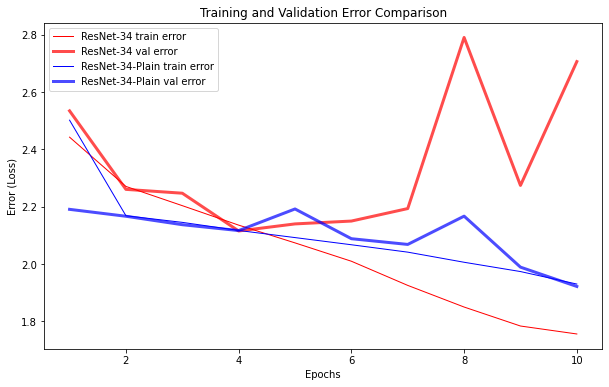

In [33]:
compare_history_error(resnet_34_history, resnet_34_plain_history, 'ResNet-34', 'ResNet-34-Plain')

- 학습이 더 되고 있다. 
- resnet-34 가 plain 모델보다 loss값이 더 큰 그래프이지만 plain 모델 같은 경우 gradient vanish 문제로 짧은 layer안에서 기울기가 수렴되는 거 같다.
- plain 같은 경우 gradient vanish 문제로 역전파 과정중에서 가중치가 업데이트 안된 부분이 있어서 학습이 빨리 진행된거 같다.
- train loss 는 감소하는데 validation loss값은 증가하는 지점이 있지만 9 epochs정도에 다시 감소되어 있는 것을 보아 완전한 과적합은 아니다.
- epochs를 늘러야 한다.

In [34]:
resnet_50.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
resnet_50_history= resnet_50.fit(ds_train, epochs = 10, validation_data = ds_test)

Epoch 1/10
 191/1164 [===>..........................] - ETA: 1:21 - loss: 6.5443 - accuracy: 0.4974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:16 - loss: 6.4233 - accuracy: 0.5032

 279/1164 [======>.......................] - ETA: 1:14 - loss: 6.3866 - accuracy: 0.5052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:01 - loss: 6.2636 - accuracy: 0.5196

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 27s - loss: 6.1473 - accuracy: 0.5299

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 25s - loss: 6.1429 - accuracy: 0.5318

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 23s - loss: 6.1395 - accuracy: 0.5324

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 18s - loss: 6.1334 - accuracy: 0.5325

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 17s - loss: 6.1317 - accuracy: 0.5329

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 6.1104 - accuracy: 0.5380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 121s 93ms/step - loss: 6.1104 - accuracy: 0.5380 - val_loss: 6.0227 - val_accuracy: 0.5669
Epoch 2/10
 192/1164 [===>..........................] - ETA: 1:23 - loss: 6.0082 - accuracy: 0.5654

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:18 - loss: 6.0083 - accuracy: 0.5647

 277/1164 [======>.......................] - ETA: 1:16 - loss: 6.0062 - accuracy: 0.5650

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:03 - loss: 6.0085 - accuracy: 0.5607

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1164 [====================>.........] - ETA: 27s - loss: 6.0051 - accuracy: 0.5614

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 25s - loss: 6.0039 - accuracy: 0.5627

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 23s - loss: 6.0038 - accuracy: 0.5631

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 18s - loss: 6.0020 - accuracy: 0.5649

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 17s - loss: 6.0014 - accuracy: 0.5654

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9989 - accuracy: 0.5680

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 113s 94ms/step - loss: 5.9989 - accuracy: 0.5680 - val_loss: 6.0759 - val_accuracy: 0.5531
Epoch 3/10
 190/1164 [===>..........................] - ETA: 1:23 - loss: 5.9807 - accuracy: 0.5780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:18 - loss: 5.9789 - accuracy: 0.5832

 280/1164 [======>.......................] - ETA: 1:15 - loss: 5.9798 - accuracy: 0.5808

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:03 - loss: 5.9797 - accuracy: 0.5817

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 28s - loss: 5.9760 - accuracy: 0.5829

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 25s - loss: 5.9754 - accuracy: 0.5824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 23s - loss: 5.9747 - accuracy: 0.5836

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 19s - loss: 5.9733 - accuracy: 0.5854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 18s - loss: 5.9733 - accuracy: 0.5856

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9712 - accuracy: 0.5862

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 109s 92ms/step - loss: 5.9712 - accuracy: 0.5862 - val_loss: 5.9777 - val_accuracy: 0.5851
Epoch 4/10
 193/1164 [===>..........................] - ETA: 1:23 - loss: 5.9582 - accuracy: 0.6075

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:18 - loss: 5.9512 - accuracy: 0.6131

 280/1164 [======>.......................] - ETA: 1:16 - loss: 5.9520 - accuracy: 0.6123

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:03 - loss: 5.9505 - accuracy: 0.6121

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 28s - loss: 5.9483 - accuracy: 0.6077

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 25s - loss: 5.9467 - accuracy: 0.6092

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 23s - loss: 5.9465 - accuracy: 0.6091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 19s - loss: 5.9469 - accuracy: 0.6077

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 17s - loss: 5.9460 - accuracy: 0.6082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9457 - accuracy: 0.6063

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 110s 92ms/step - loss: 5.9457 - accuracy: 0.6063 - val_loss: 5.9389 - val_accuracy: 0.6126
Epoch 5/10
 192/1164 [===>..........................] - ETA: 1:23 - loss: 5.9363 - accuracy: 0.5996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1164 [=====>........................] - ETA: 1:17 - loss: 5.9393 - accuracy: 0.6009

 280/1164 [======>.......................] - ETA: 1:15 - loss: 5.9412 - accuracy: 0.5973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:03 - loss: 5.9441 - accuracy: 0.5898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 27s - loss: 5.9330 - accuracy: 0.6037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1164 [=====================>........] - ETA: 25s - loss: 5.9315 - accuracy: 0.6051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 23s - loss: 5.9311 - accuracy: 0.6056

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 19s - loss: 5.9296 - accuracy: 0.6061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 18s - loss: 5.9294 - accuracy: 0.6065

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9278 - accuracy: 0.6090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 110s 92ms/step - loss: 5.9278 - accuracy: 0.6090 - val_loss: 5.8940 - val_accuracy: 0.6356
Epoch 6/10
 191/1164 [===>..........................] - ETA: 1:23 - loss: 5.9091 - accuracy: 0.6214

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:18 - loss: 5.9112 - accuracy: 0.6179

 276/1164 [======>.......................] - ETA: 1:16 - loss: 5.9152 - accuracy: 0.6155

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1164 [==========>...................] - ETA: 1:03 - loss: 5.9144 - accuracy: 0.6122

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 27s - loss: 5.9102 - accuracy: 0.6143

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 25s - loss: 5.9102 - accuracy: 0.6143

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 23s - loss: 5.9102 - accuracy: 0.6145

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 18s - loss: 5.9092 - accuracy: 0.6151

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 17s - loss: 5.9097 - accuracy: 0.6148

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9068 - accuracy: 0.6166

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 113s 94ms/step - loss: 5.9068 - accuracy: 0.6166 - val_loss: 5.8952 - val_accuracy: 0.6225
Epoch 7/10
 197/1164 [====>.........................] - ETA: 1:22 - loss: 5.9023 - accuracy: 0.6171

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:17 - loss: 5.8996 - accuracy: 0.6152

 279/1164 [======>.......................] - ETA: 1:15 - loss: 5.8966 - accuracy: 0.6178

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:03 - loss: 5.8973 - accuracy: 0.6151

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 27s - loss: 5.8874 - accuracy: 0.6252

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 25s - loss: 5.8883 - accuracy: 0.6241

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 23s - loss: 5.8881 - accuracy: 0.6238

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 19s - loss: 5.8873 - accuracy: 0.6242

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 18s - loss: 5.8871 - accuracy: 0.6248

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.8820 - accuracy: 0.6292

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 109s 92ms/step - loss: 5.8820 - accuracy: 0.6292 - val_loss: 6.1239 - val_accuracy: 0.5720
Epoch 8/10
 196/1164 [====>.........................] - ETA: 1:23 - loss: 5.8805 - accuracy: 0.6237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:18 - loss: 5.8758 - accuracy: 0.6290

 277/1164 [======>.......................] - ETA: 1:16 - loss: 5.8719 - accuracy: 0.6318

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:03 - loss: 5.8754 - accuracy: 0.6254

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 28s - loss: 5.8654 - accuracy: 0.6331

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 25s - loss: 5.8646 - accuracy: 0.6346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 23s - loss: 5.8634 - accuracy: 0.6349

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 19s - loss: 5.8631 - accuracy: 0.6353

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 18s - loss: 5.8636 - accuracy: 0.6348

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.8619 - accuracy: 0.6361

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 109s 92ms/step - loss: 5.8619 - accuracy: 0.6361 - val_loss: 6.0818 - val_accuracy: 0.5488
Epoch 9/10
 194/1164 [====>.........................] - ETA: 1:23 - loss: 5.8479 - accuracy: 0.6437

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:18 - loss: 5.8490 - accuracy: 0.6403

 279/1164 [======>.......................] - ETA: 1:16 - loss: 5.8498 - accuracy: 0.6414

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:03 - loss: 5.8515 - accuracy: 0.6375

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 27s - loss: 5.8434 - accuracy: 0.6442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 25s - loss: 5.8434 - accuracy: 0.6436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 24s - loss: 5.8429 - accuracy: 0.6443

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 19s - loss: 5.8412 - accuracy: 0.6449

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 18s - loss: 5.8416 - accuracy: 0.6449

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.8395 - accuracy: 0.6457

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 110s 92ms/step - loss: 5.8395 - accuracy: 0.6457 - val_loss: 5.8154 - val_accuracy: 0.6597
Epoch 10/10
 197/1164 [====>.........................] - ETA: 1:23 - loss: 5.8215 - accuracy: 0.6612

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1164 [=====>........................] - ETA: 1:18 - loss: 5.8217 - accuracy: 0.6555

 276/1164 [======>.......................] - ETA: 1:16 - loss: 5.8240 - accuracy: 0.6538

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:03 - loss: 5.8264 - accuracy: 0.6511

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 27s - loss: 5.8204 - accuracy: 0.6492

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 26s - loss: 5.8214 - accuracy: 0.6487

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 24s - loss: 5.8220 - accuracy: 0.6477

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 19s - loss: 5.8216 - accuracy: 0.6484

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 18s - loss: 5.8215 - accuracy: 0.6484

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.8181 - accuracy: 0.6515

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 113s 95ms/step - loss: 5.8181 - accuracy: 0.6515 - val_loss: 5.8960 - val_accuracy: 0.6139


In [36]:
resnet_50_plain.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
resnet_50_plain_history = resnet_50_plain.fit(ds_train, epochs = 10, validation_data = ds_test)

Epoch 1/10
 191/1164 [===>..........................] - ETA: 1:11 - loss: 6.2417 - accuracy: 0.5118

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 250/1164 [=====>........................] - ETA: 1:07 - loss: 6.0087 - accuracy: 0.5123

 277/1164 [======>.......................] - ETA: 1:05 - loss: 5.9330 - accuracy: 0.5167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 54s - loss: 5.6948 - accuracy: 0.5195

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 24s - loss: 5.4740 - accuracy: 0.5188

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 22s - loss: 5.4667 - accuracy: 0.5193

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 20s - loss: 5.4605 - accuracy: 0.5201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 16s - loss: 5.4477 - accuracy: 0.5202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 15s - loss: 5.4448 - accuracy: 0.5204

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.4074 - accuracy: 0.5210

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 105s 81ms/step - loss: 5.4074 - accuracy: 0.5210 - val_loss: 5.2309 - val_accuracy: 0.5479
Epoch 2/10
 191/1164 [===>..........................] - ETA: 1:13 - loss: 5.2336 - accuracy: 0.5314

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:08 - loss: 5.2364 - accuracy: 0.5255

 280/1164 [======>.......................] - ETA: 1:06 - loss: 5.2369 - accuracy: 0.5228

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 55s - loss: 5.2359 - accuracy: 0.5190

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 24s - loss: 5.2345 - accuracy: 0.5191

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 22s - loss: 5.2342 - accuracy: 0.5197

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 20s - loss: 5.2344 - accuracy: 0.5201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 16s - loss: 5.2344 - accuracy: 0.5202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 15s - loss: 5.2341 - accuracy: 0.5207

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.2336 - accuracy: 0.5203

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.2336 - accuracy: 0.5203 - val_loss: 5.2305 - val_accuracy: 0.5112
Epoch 3/10
 190/1164 [===>..........................] - ETA: 1:13 - loss: 5.2301 - accuracy: 0.5089

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:08 - loss: 5.2299 - accuracy: 0.5107

 280/1164 [======>.......................] - ETA: 1:06 - loss: 5.2298 - accuracy: 0.5134

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 55s - loss: 5.2313 - accuracy: 0.5110

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 24s - loss: 5.2284 - accuracy: 0.5165

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 22s - loss: 5.2279 - accuracy: 0.5162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 20s - loss: 5.2279 - accuracy: 0.5151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 16s - loss: 5.2278 - accuracy: 0.5141

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 15s - loss: 5.2278 - accuracy: 0.5138

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.2276 - accuracy: 0.5130

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.2276 - accuracy: 0.5130 - val_loss: 5.2223 - val_accuracy: 0.4968
Epoch 4/10
 195/1164 [====>.........................] - ETA: 1:12 - loss: 5.2187 - accuracy: 0.5157

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:08 - loss: 5.2197 - accuracy: 0.5134

 277/1164 [======>.......................] - ETA: 1:06 - loss: 5.2199 - accuracy: 0.5147

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 55s - loss: 5.2217 - accuracy: 0.5077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 24s - loss: 5.2212 - accuracy: 0.5052

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 22s - loss: 5.2211 - accuracy: 0.5064

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 20s - loss: 5.2210 - accuracy: 0.5063

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 16s - loss: 5.2209 - accuracy: 0.5067

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 15s - loss: 5.2211 - accuracy: 0.5062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.2192 - accuracy: 0.5093

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.2192 - accuracy: 0.5093 - val_loss: 5.2378 - val_accuracy: 0.4951
Epoch 5/10
 193/1164 [===>..........................] - ETA: 1:12 - loss: 5.2155 - accuracy: 0.5039

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:08 - loss: 5.2146 - accuracy: 0.5032

 279/1164 [======>.......................] - ETA: 1:06 - loss: 5.2150 - accuracy: 0.5002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 55s - loss: 5.2160 - accuracy: 0.5003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 24s - loss: 5.2124 - accuracy: 0.5052

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 22s - loss: 5.2122 - accuracy: 0.5055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1164 [=====================>........] - ETA: 20s - loss: 5.2121 - accuracy: 0.5058

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1164 [=======================>......] - ETA: 16s - loss: 5.2121 - accuracy: 0.5055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1164 [=======================>......] - ETA: 15s - loss: 5.2121 - accuracy: 0.5056

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.2109 - accuracy: 0.5093

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.2109 - accuracy: 0.5093 - val_loss: 5.2502 - val_accuracy: 0.5099
Epoch 6/10
 191/1164 [===>..........................] - ETA: 1:13 - loss: 5.2045 - accuracy: 0.5262

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:08 - loss: 5.2036 - accuracy: 0.5272

 277/1164 [======>.......................] - ETA: 1:06 - loss: 5.2039 - accuracy: 0.5259

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 55s - loss: 5.2037 - accuracy: 0.5238

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 24s - loss: 5.2023 - accuracy: 0.5206

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 22s - loss: 5.2020 - accuracy: 0.5213

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 21s - loss: 5.2020 - accuracy: 0.5204

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 16s - loss: 5.2017 - accuracy: 0.5219

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 16s - loss: 5.2017 - accuracy: 0.5216

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.2010 - accuracy: 0.5196

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.2010 - accuracy: 0.5196 - val_loss: 5.2721 - val_accuracy: 0.5189
Epoch 7/10
 192/1164 [===>..........................] - ETA: 1:13 - loss: 5.1988 - accuracy: 0.5173

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1164 [=====>........................] - ETA: 1:07 - loss: 5.1982 - accuracy: 0.5145

 275/1164 [======>.......................] - ETA: 1:06 - loss: 5.1992 - accuracy: 0.5111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 55s - loss: 5.2001 - accuracy: 0.5044

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1164 [====================>.........] - ETA: 24s - loss: 5.1961 - accuracy: 0.5095

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 22s - loss: 5.1958 - accuracy: 0.5107

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 20s - loss: 5.1955 - accuracy: 0.5115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 16s - loss: 5.1955 - accuracy: 0.5106

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 15s - loss: 5.1954 - accuracy: 0.5107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.1948 - accuracy: 0.5107

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.1948 - accuracy: 0.5107 - val_loss: 5.3485 - val_accuracy: 0.4908
Epoch 8/10
 195/1164 [====>.........................] - ETA: 1:12 - loss: 5.1938 - accuracy: 0.4926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1164 [=====>........................] - ETA: 1:07 - loss: 5.1918 - accuracy: 0.4961

 278/1164 [======>.......................] - ETA: 1:06 - loss: 5.1914 - accuracy: 0.4984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 55s - loss: 5.1911 - accuracy: 0.5007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1164 [====================>.........] - ETA: 24s - loss: 5.1891 - accuracy: 0.5019

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 22s - loss: 5.1889 - accuracy: 0.5022

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 20s - loss: 5.1889 - accuracy: 0.5017

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 16s - loss: 5.1886 - accuracy: 0.5020

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 15s - loss: 5.1885 - accuracy: 0.5016

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.1871 - accuracy: 0.5048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.1871 - accuracy: 0.5048 - val_loss: 5.2023 - val_accuracy: 0.5073
Epoch 9/10
 193/1164 [===>..........................] - ETA: 1:12 - loss: 5.1812 - accuracy: 0.5175

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:08 - loss: 5.1807 - accuracy: 0.5122

 275/1164 [======>.......................] - ETA: 1:06 - loss: 5.1812 - accuracy: 0.5127

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 55s - loss: 5.1797 - accuracy: 0.5140

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 24s - loss: 5.1776 - accuracy: 0.5103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 22s - loss: 5.1774 - accuracy: 0.5100

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 20s - loss: 5.1774 - accuracy: 0.5093

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 16s - loss: 5.1776 - accuracy: 0.5094

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 15s - loss: 5.1774 - accuracy: 0.5101

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.1763 - accuracy: 0.5111

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.1763 - accuracy: 0.5111 - val_loss: 5.2655 - val_accuracy: 0.5327
Epoch 10/10
 195/1164 [====>.........................] - ETA: 1:12 - loss: 5.1723 - accuracy: 0.5022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:08 - loss: 5.1712 - accuracy: 0.5062

 278/1164 [======>.......................] - ETA: 1:06 - loss: 5.1711 - accuracy: 0.5052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 55s - loss: 5.1708 - accuracy: 0.5009

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 24s - loss: 5.1684 - accuracy: 0.5083

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 22s - loss: 5.1685 - accuracy: 0.5086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 20s - loss: 5.1682 - accuracy: 0.5091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 16s - loss: 5.1681 - accuracy: 0.5093

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 15s - loss: 5.1681 - accuracy: 0.5096

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.1663 - accuracy: 0.5107

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 96s 80ms/step - loss: 5.1663 - accuracy: 0.5107 - val_loss: 5.1735 - val_accuracy: 0.5443


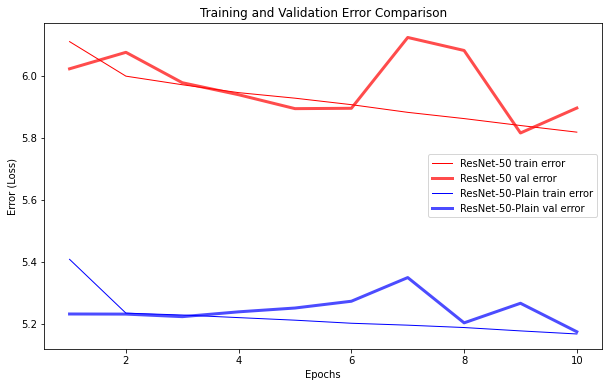

In [38]:
compare_history_error(resnet_50_history, resnet_50_plain_history, 'ResNet-50', 'ResNet-50-Plain')

- resnet-50이 plain 모델보다 loss 값이 초기보다 높게 나왔다.... sgd로 랜덤한 지점을 찾아서 경사하강법으로 내려가서 초기에는 높게 나온거 같다.

## 회고
dl_ton 휴유증 때문에 노드 못 끝내면 잠이 안온다

노드에 있는 그대로 repeat 쓰니깐 내가 만든 class fit에서는 step_per_epochs = 0 이 나오는 문제가 생겼다. 앞으로 어떤 메서드인지 확인하고 써야겠다.